# "Преамбула"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.4 MB/s eta 0:00:00


## Импорт библиотек для анализа данных

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

%matplotlib inline

# Вступление

В данном соревновании перед нами стоит задача предсказания: выживет ли пассажир или нет, причём метрикой оценки качества модели является доля правильных ответов (Accuracy). Если интерпретировать данную задачу на язык машинного обучения, то получается, что мы должны постороить бинарный классификатор, который выдаёт 0, если по предположению модели пассажир не выживет, иначе 1.

Существуют разные подходы к классификации, мы хотим рассмотреть одни из самых популярных и более-менее интерпретируемых (относительно black-box нейронных сетей):
1. Логистическую регрессию
2. Дерево решений
3. Случайный лес
4. Градиентный бустинг

Алгоритм k-means, по нашему мнению, использовать не очень рационально, поскольку он больше про обучение без учителя, а также требует очень много вычислительных ресурсов, так как каждый объект будет иметь больше 2 признаков, а значит придётся рассматривать его в многомерном пространстве, что будет к тому же долго, ведь для каждого объекта алгоритм предполагает вычисление расстояния для каждого из соседей.

# 1. EDA (Разведочный анализ данных)

## Смотрим на данные

Для начала поймём, что имеем. Любезные организаторы предоставили нам два датасета: train.csv и test.csv. Первый нужен для построения модели, её обучения, поскольку для каждого объекта там указан "вердикт" выжил человек или нет, второй нужен для проверки качества модели.

In [3]:
# train = pd.read_csv("/content/sample_data/train.csv")
train = pd.read_csv('/content/train.csv')

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.shape

(891, 12)

In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Рассмотрим смысл данных колонок, чтобы исходя из здравого смысла прикинуть какие из них могут влиять на предсказание в наибольшей степени.

- **PassengerId** - id пассажира. Такой признак может помешать нам при обучении модели, поскольук она может просто для каждого пассажира запомнить выжил он или нет, и тогда обобщающая способность будет низкой, просто переобучимся на данных, значит от него нужно избавиться.
- **Survived** - выжил человек или нет, в трейне он нам не нужен, потом дропнем.
- **Pclass** - показатель социально-экономического статуса (1 - наивысший), есть предположения, что людей с наивысшим статусом охотнее спасали (обычно более влиятельных людей стремяться спасти).
- **Name** - имя, оно тоже будет нам мешать при обучении, так как здравый смысл подсказывает, что имя вряд ли скоррелированно с выживаемостью, опять таки модель может просто запомнить имена выживших и переобучится.
- **Sex** - пол, кажется что этот признак будет одним из важных, поскольку в реальной жизни обычно в первую очередь спасают женщин и детей.
- **Age** - возраст, по нему есть предположение, что более молодые выживали, потому что это дети, которых, как написано в пункте выше, спасали охотнее.
- **SibSp** - число братьев и сестёр / супругов на борту "Титаника", есть предположения, что эти статусы будут немного влиять на выживаемость, потому что они связаны одновременно и с возрастом, и с полом, плюс, если человек брат кому-то, то скорее он захочет не только спастись сам, но и спасти своих родных, то есть семьями могут выживать, если это жена, то она может выжить благодаря мужу, который позаботиться о ней.
- **Parch** - число родителей / детей на борту, есть идея, что если у человека, особенно женщины, много детей на борту, то она спасётся вместе с детьми.
- **Ticket** - номер билета, он в целом может влиять, например, при экстренных ситуациях обычно спасают богатых, а номера билета могут коррелировать с типом социального статуса, но здесь нужно найти закономерность в генерации номеров, это довольно сложно и не факт, что такой признак даст профит.
- **Fare** - стоимость билета, может быть важным признаком, при теории, что богатых спасают, а зачастую стоимоть билета отражает статус человека.
- **Cabin** - номер кабины, здесь номер кабины может что-то дать, например, корабль может тонуть с одной стороны его может затапливать, а с другой нет, поэтому кабины с определённым номерами заполняются водой быстрее, и как следствие, люди умирают там быстрее, НО здесь много пропусков, поэтому, кажется, что будет трудно вытянуть полезную информацию из этого признака.
- **Embarked** - порт посадки, адекватных предложений как этот признак мог влиять нет, только если все богатые люди садились в определённом порту, что скореллированно с социальным статусом и ценой на билет, или новоприбывшие люди оставались на палубе, и, как следствие, спасались быстрее, так как узнали о случившимся первыми.

In [4]:
train.drop('PassengerId', axis=1, inplace=True)

## Боремся с пропусками

На данном этапе можно заметить, что есть довольно много пропусков в колонке Cabin, так же есть некоторое количество пропусков в Age и Embarked. Обычно, если в колонке не так много пропусков, их заменяют "нейтральными" элементами по колонке, например, среднее / медиана.

In [5]:
train['Cabin'].isnull().sum() / len(train['Cabin'])

0.7710437710437711

In [6]:
train['Age'].isnull().sum() / len(train['Age'])

0.19865319865319866

In [7]:
train['Embarked'].isnull().sum() / len(train['Embarked'])

0.002244668911335578

Пропусков в Cabin крайне много, больше половины, поэтому усреднять смысла особого нет, дропнем эту колонку, другие же колонки имеют не так много пропусков, пропуски в Age заполним средним значением (так как это числовой признак), а Embarked модой.

In [8]:
train.drop('Cabin', axis=1, inplace=True)

In [9]:
train['Age'] = train['Age'].fillna(train['Age'].mean())

In [10]:
norm_mode = train[~(train['Embarked'].isna())]['Embarked'].mode()
train['Embarked'] = train['Embarked'].fillna(norm_mode)

## Выбираем признаки

Пока переключимся на данные и их числовые характеристики. Посмотрим на соотношение выживших и умерших, то есть на соотношение наших двух классов, если будет дисбаланс, то придётся думать как решать данную проблему.

In [11]:
is_surv = train.groupby('Survived', as_index=False).count()
died, live = is_surv['Age']
print(died / (died + live),live / (died + live))

0.6161616161616161 0.3838383838383838


Погибших людей больше, но различия в количествах объектов классов не критичная, то есть сильного дисбаланса классов нет, а значит, можно сразу загонять данные в модель и обучаться на них.

Рассмотрим распределение признаков.

In [ ]:
columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

In [ ]:
def raspr(df, column):
  df[column].hist(bins=50)
  plt.xlabel(column)
  plt.ylabel('Частота')
  return plt

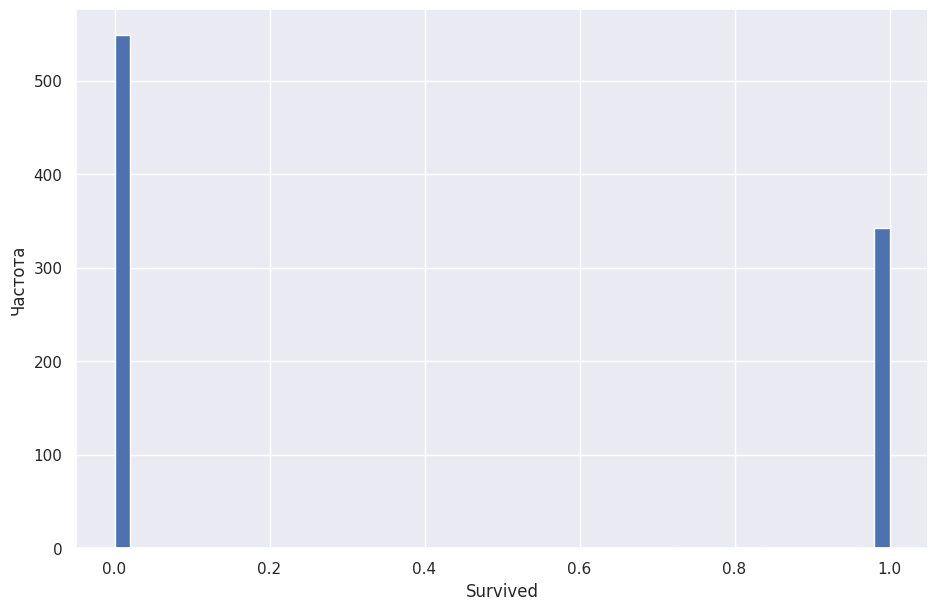

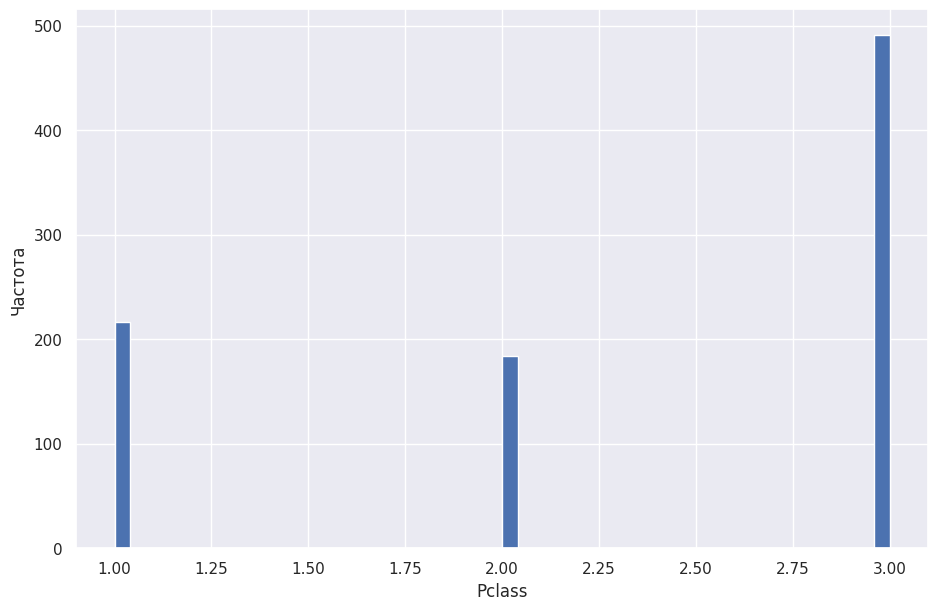

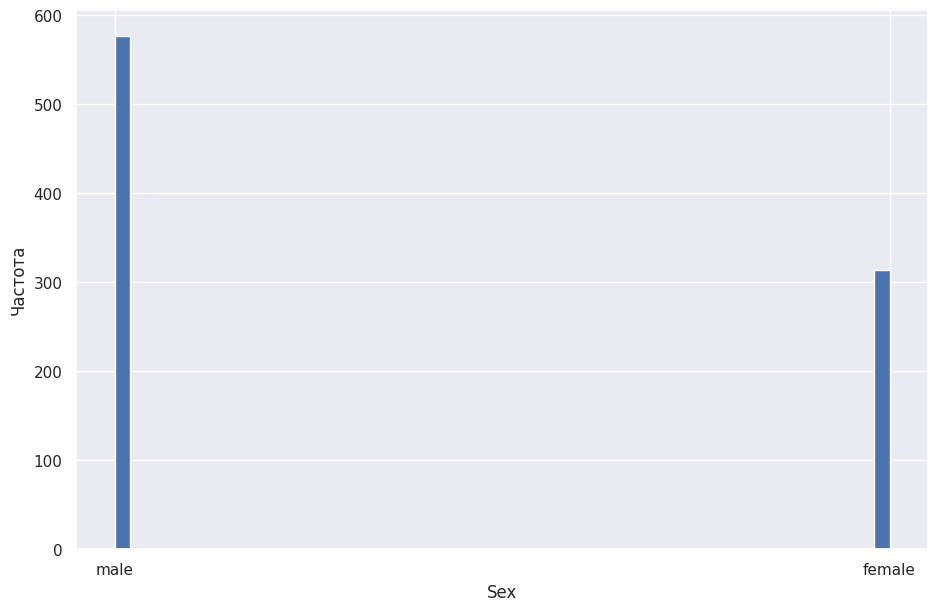

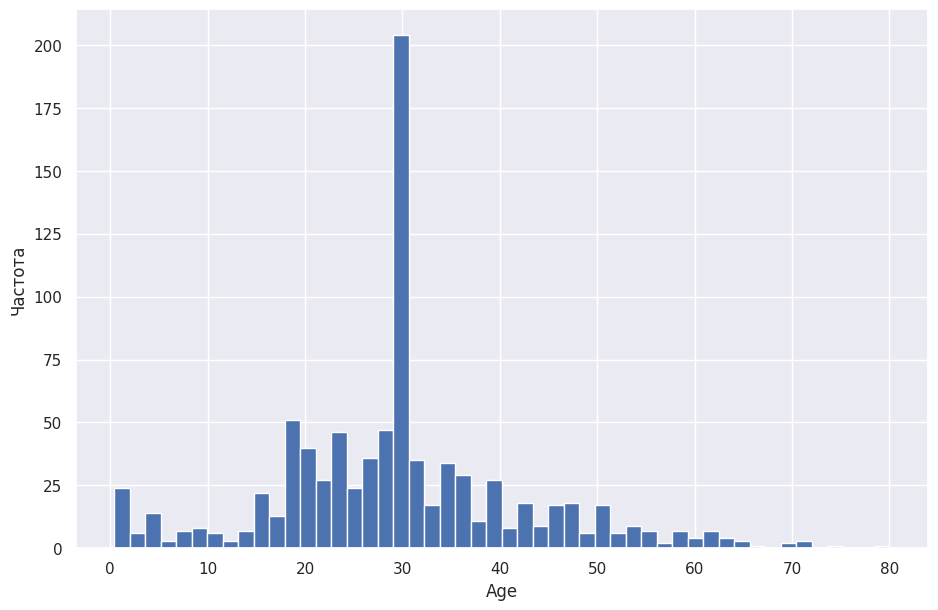

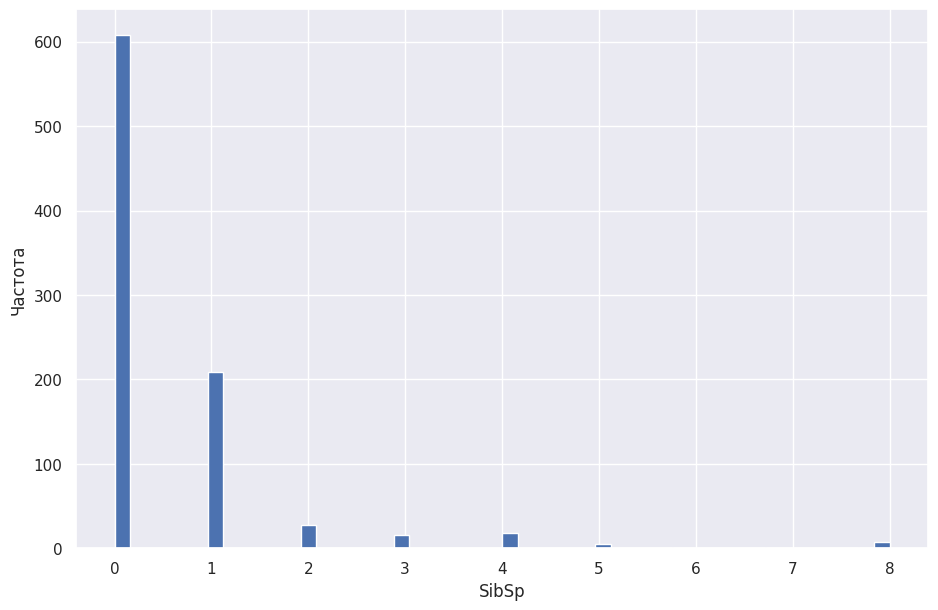

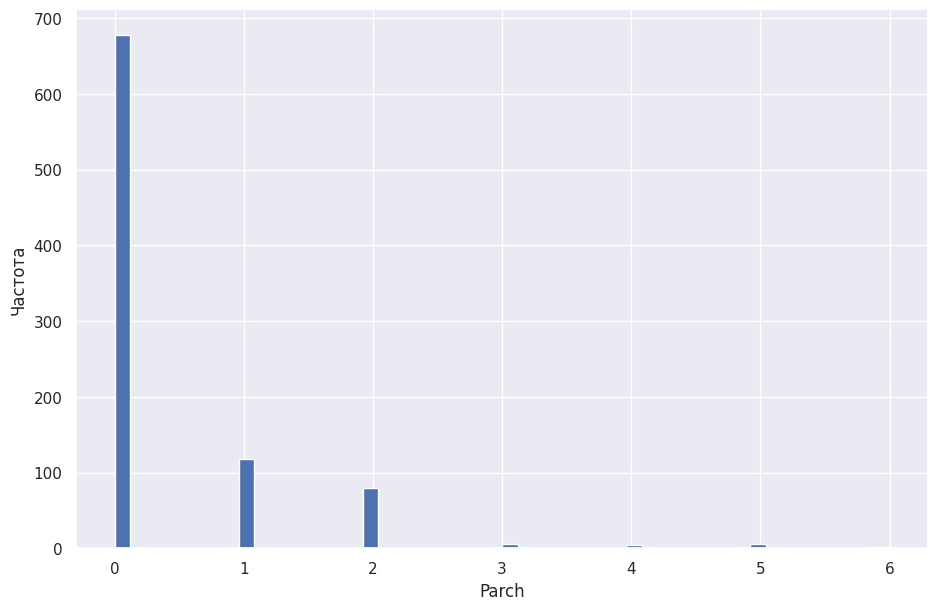

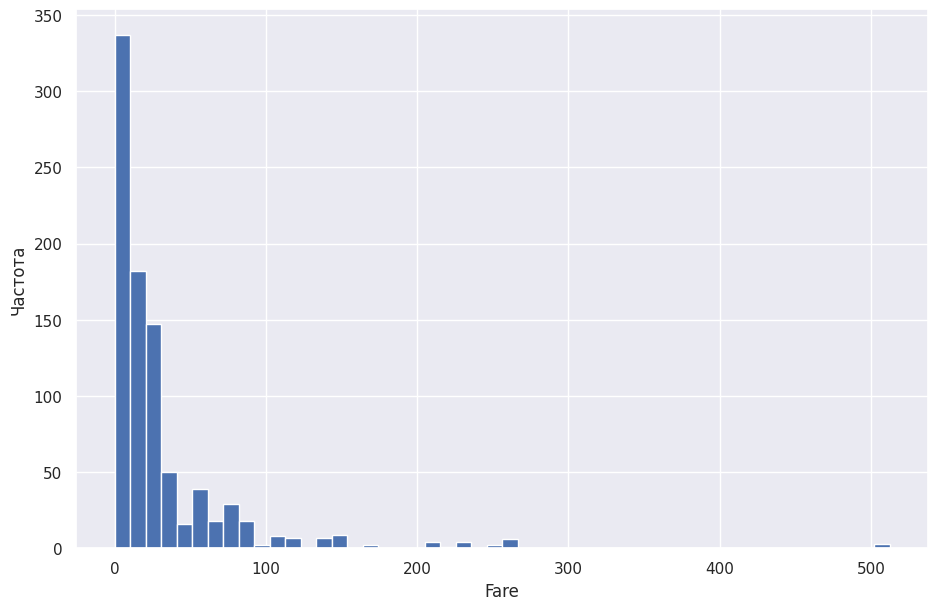

In [ ]:
for col in columns:
  raspr(train, col).show()

Благодаря таким графикам мы можем сделать анализ и примерно представить себе людей, которые были на Титанике.
- Людей третьего класса было столько же, сколько первого и второго в сумме, а первого и второго почти поровну.
- Женщин было почти в два раза больше, чем мужчин.
- Распределение возраста отадлённо напоминает нормальное распределение, больше всего людей, которым 20-30 лет, а также детей больше, чем пожилых.
- Большинство не имело родственников, но у кого-то было 8 родственников на борту.
- Людей без детей больше, чем с детьми.
- Много кто купил дешёвые билеты.

### Посмотрим на различные корреляции

После выдвижения гипотез о том, какие признаки действительно могут влиять, нужно проверить верны ли они, то есть понять, какие признаки можно убрать без потери или даже с улучшением качества модели. Хороший способ - это посмотреть на корреляцию признаков между собой и выживаемостью.

Так как есть категориальные переменные, то их нужно векторизовать, чтобы можно было посчитать коэффициент корреляции

<ipython-input-12-1e011bff75f9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_corr[i] = labels
<ipython-input-12-1e011bff75f9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_corr[i] = labels
<ipython-input-12-1e011bff75f9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<Axes: >

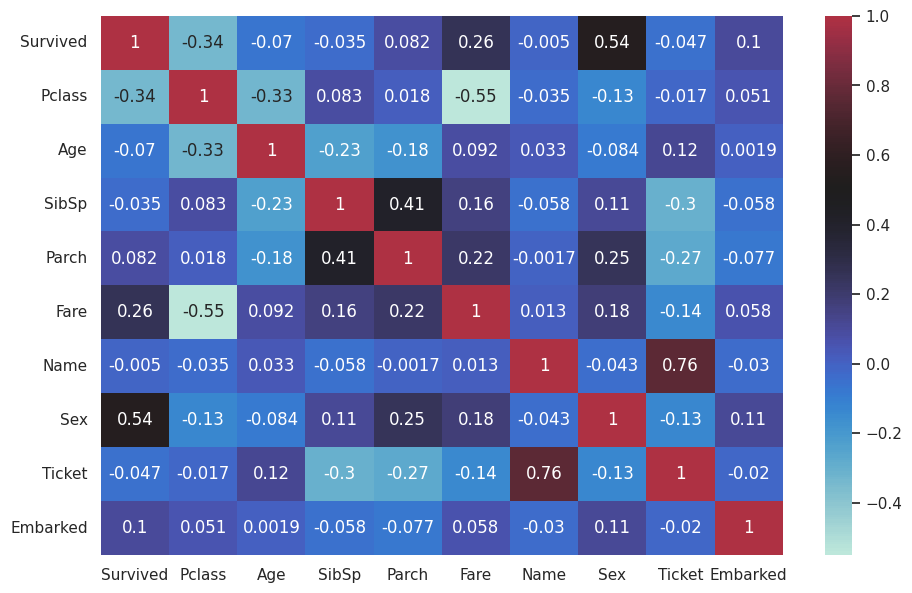

In [12]:
from pandas import factorize
for_corr = train[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
to_factor = ['Name', 'Sex', 'Ticket', 'Embarked']
for i in to_factor:
    labels, categories = factorize(train[i])
    for_corr[i] = labels
sns.set_theme(rc={'figure.figsize':(11, 7)})
sns.heatmap(for_corr.corr(), center=0.5, annot=True)

Исходя из таблицы корреляций, можно сделать такие выводы:
- Survived сильно (относительно других признаков) коррелирует с Sex.
- Survived отрицательно коррелирует с классом, то есть чем ниже (1 - наивысший) класс, тем меньше людей выживают.
- Survived положительно коррелирует с Fare, что логично: чем выше цена, тем выше класс билета (это видно из корреляции Pclass и Fare).
- Ticket слабо коррелирует с выживаемостью, к тому же номер билета подразумевает идентичность, а значит модель из-за этого может переобучиться, лучше дропнуть данный признак на текущем этапе.
- Name коррелирует с Ticket, то есть, они фактически взаимозаменяемы, то есть тоже надо дропнуть.
  
Большинство гипотез, описанных нами при исследовании колонок, оказались верны.

In [13]:
train.drop('Ticket', axis=1, inplace=True)

In [14]:
train.drop('Name', axis=1, inplace=True)

### Поисследуем сильно коррелирующие с выживаемостью признаки

Раз видна связь между выживаемостью и полом, то нужно взглянуть на распределение количества выживших женщин и мужчи.

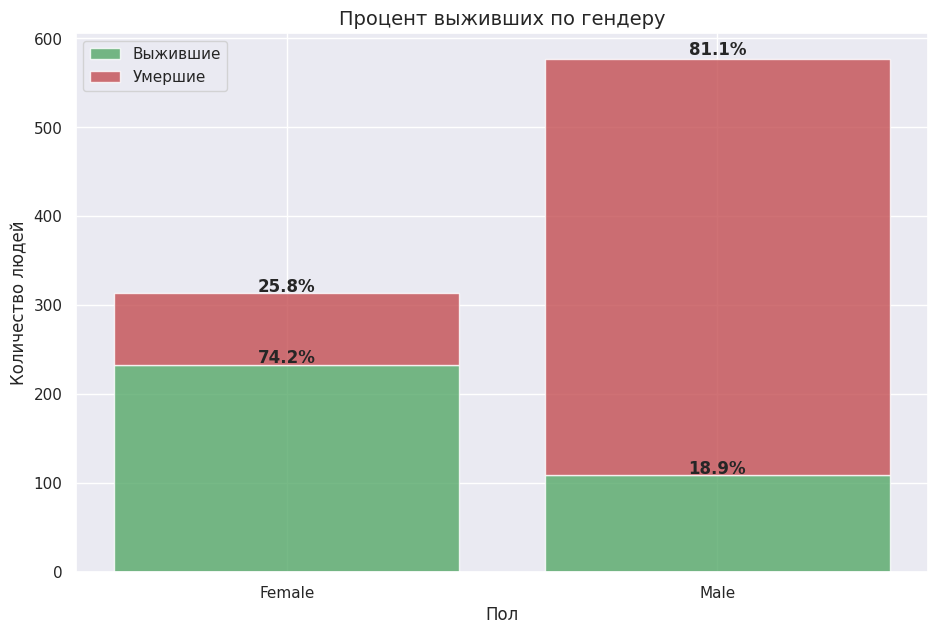

In [15]:
surv = train[train['Survived'] == 1]
no_surv = train[train['Survived'] == 0]

surv_by_gender = surv.groupby('Sex').size().values
no_surv_by_gender = no_surv.groupby('Sex').size().values
genders = ["Female", "Male"]

per_woman_surv = surv.groupby('Sex').size().values[0] / (no_surv.groupby("Sex").size().values[0] + surv.groupby("Sex").size().values[0]) * 100
per_woman_no_surv = 100 - per_woman_surv

per_man_surv = surv.groupby('Sex').size().values[1] / (no_surv.groupby("Sex").size().values[1] + surv.groupby("Sex").size().values[1]) * 100
per_man_no_surv = 100 - per_man_surv

all_per = [per_woman_surv, per_man_surv, per_woman_no_surv, per_man_no_surv]



f, ax = plt.subplots(1, figsize=(11, 7))
ax.bar(range(len(surv_by_gender)), surv_by_gender, label='Выжившие', alpha=0.8, color='g')
ax.bar(range(len(no_surv_by_gender)), no_surv_by_gender, bottom=surv_by_gender, label='Умершие', alpha=0.8, color='r')
plt.sca(ax)
plt.xticks([0, 1], genders)
ax.set_ylabel("Количество людей")
ax.set_xlabel("Пол")
ax.set_title("Процент выживших по гендеру",fontsize=14)
plt.legend(loc='upper left')

i = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x + width / 2, y + height * 1.01, str(round(all_per[i], 1)) + "%", ha="center", weight='bold')
    i += 1



Как видно из гистограммы, процент выживших женщин от всех женщин гораздо выше, чем процент выживших мужчин от всех мужчин, значит наша теория "женщин (и детей) спасают первыми" верна.

Теперь посмотрим класс, в котором был пассажир, это вторая по абсолютному значению величина, которая коррелирует с выживаемостью

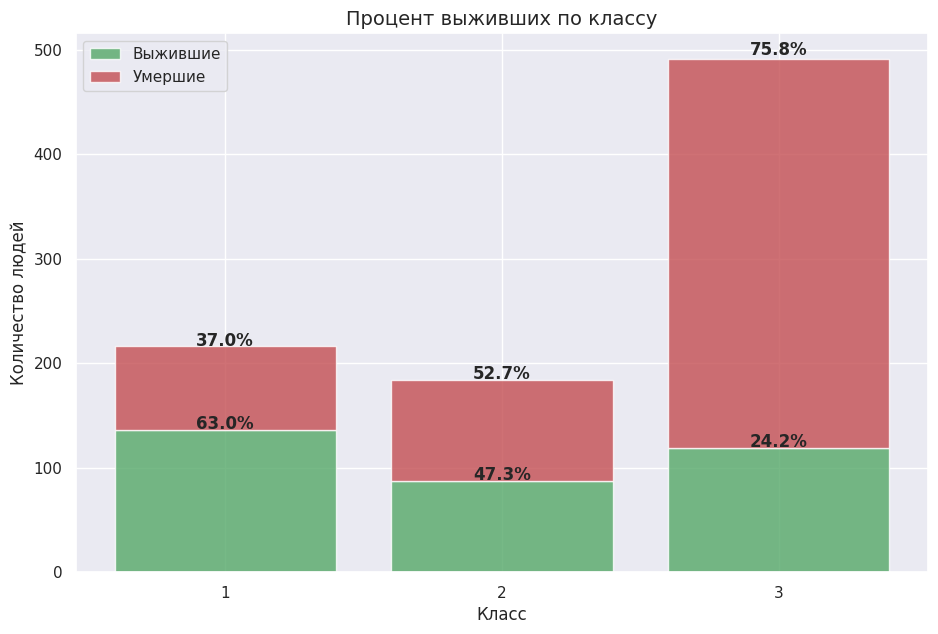

In [16]:
surv_by_class = surv.groupby("Pclass").size().values
no_surv_by_class = no_surv.groupby("Pclass").size().values
classes = [1, 2, 3]

f_surv = surv.groupby("Pclass").size().values[0]
f_no_surv = no_surv.groupby("Pclass").size().values[0]

p_f_surv = f_surv / (f_surv + f_no_surv) * 100
p_f_no_surv = f_no_surv / (f_surv + f_no_surv) * 100

s_surv = surv.groupby("Pclass").size().values[1]
s_no_surv = no_surv.groupby("Pclass").size().values[1]

p_s_surv = s_surv / (s_surv + s_no_surv) * 100
p_s_no_surv = s_no_surv / (s_surv + s_no_surv) * 100

t_surv = surv.groupby("Pclass").size().values[2]
t_no_surv = no_surv.groupby("Pclass").size().values[2]

p_t_surv = t_surv / (t_surv + t_no_surv) * 100
p_t_no_surv = t_no_surv / (t_surv + t_no_surv) * 100

all_per = [p_f_surv, p_s_surv, p_t_surv, p_f_no_surv, p_s_no_surv, p_t_no_surv]


f, ax = plt.subplots(1, figsize=(11, 7))
ax.bar(range(len(surv_by_class)), surv_by_class, label='Выжившие', alpha=0.8, color='g')
ax.bar(range(len(no_surv_by_class)), no_surv_by_class, bottom=surv_by_class, label='Умершие', alpha=0.8, color='r')
plt.sca(ax)
plt.xticks([0, 1, 2], classes)
ax.set_ylabel("Количество людей")
ax.set_xlabel("Класс")
ax.set_title("Процент выживших по классу",fontsize=14)
plt.legend(loc='upper left')

i = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x + width / 2, y + height * 1.01, str(round(all_per[i], 1)) + "%", ha="center", weight='bold')
    i += 1

Из текущей диаграммы видно, что процент выживших людей от всех людей почти в три и в два раза выше в первом и во втором классе, нежели в третьем

Теперь рассмотрим распределение выживших относительно стоимости билета.

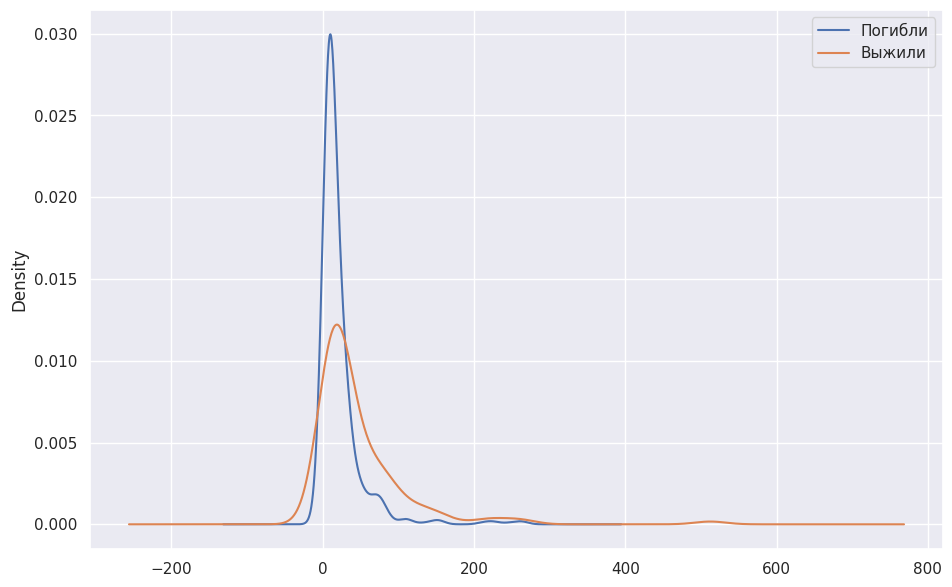

In [ ]:
train.groupby('Survived')['Fare'].plot(kind='kde')
plt.legend(['Погибли', 'Выжили'])
plt.show()

Можно заметить, что чем выше стоимоть билета, тем больше людей выжило.

# 2 Выбор модели и метрик

### Метрика качества

Перед нами стоит задача классификации, нужно определить выживет ли пассажир или нет, причём метрикой оценки качества является accuracy, что с одной стороны логично, ведь нужно правильно предсказывать выживет ли человек или нет, но с другой стороны, у этой метрики есть существенный недостаток: мы не можем определить по этой метрикке как модель ошибается, она присваивает выжившим метку погибшего или наоборот, считает всех выжившими. Так, например, если есть явный дисабаланс классов, например, 80% человек погибают, то, сделав константную модель (то есть предсказывающую гибель всем), мы уже получим довольно хороший score, поскольку accuracy будет 0.80, но толку от такой модели не будет. В связи с чем, мы решили брать f-score для оценки качества моделей, поскольку так мы требуем от модели обобщения закона "выживаемости", плюс ко всему при высокой оценке f-мерой будет высока и accuracy, так как мы получим качественную модель и на новых данных она будет показывать себя хорошо.

Как мы узнали, хорошей практикой в машинном обучении является следующая: деление выборки, которую нам предоставляют для обучения модели на оюучающую и валидационную. Мотивация заключается в следующем: прогоняя много раз модель для подбора параметров (кросс-валидация), мы получаем модель, которая просто запомнила данные из обучающей выборки, она может иметь высокий score на обучающей выборке, но получить экстремально низкий на реальных данных, чтобы отловить такую ситуацию от тренировочной выборки отщипляют кусочек данных, на которых проверяют качество модели (получаем валидный score, так как на такие данные наша модель не видела).

### One-hot-encoding

Теперь сделаем one-hot-encoding, чтобы можно было комфортно работать с категориальными признаками, а также разобьём исходгую обучающую выборку на валидационную и нашу тестовую.

In [17]:
cat_col = []
num_col = []
for column in train.columns:
  if train[column].dtype == float or train[column].dtype == int:
    num_col.append(column)
  else:
    cat_col.append(column)
train = pd.get_dummies(train, columns = cat_col)
scaler = MinMaxScaler()
train[num_col] = scaler.fit_transform(train[num_col])
X = train.drop(['Survived'], axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Построение моделей

### Логистическая регрессия

In [18]:
simple_reg = LogisticRegression(random_state=0).fit(X_train, y_train)
simple_reg_score = simple_reg.score(X_test, y_test)
print(simple_reg_score)

0.7947761194029851


### Логистическая регрессия с регуляризацией

Возьмем два основных метода регуляризации:

1. Ридж-регрессия (L2 регуляризация)
2. Лассо-регрессия (L1 регуляризация)

Сначала посмотрим на встроенные функции подбора параметров и гиперпараметров для регуляризаций и на score в таком случае.

In [19]:
l1_reg = LogisticRegression(random_state=0, penalty='l2', solver='saga').fit(X_train, y_train)
l1_score = l1_reg.score(X_test, y_test)
print(l1_score)

l2_reg = LogisticRegression(random_state=0, penalty='l1', solver='saga').fit(X_train, y_train)
l2_score = l2_reg.score(X_test, y_test)
print(l2_score)

0.7947761194029851
0.7985074626865671


А теперь попробуем сами подобрать нужный гиперпараметр с помощью GridSearch_CV и посмотрим на score в данном случае.

In [ ]:
alpha_values = {'alpha': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 1, 2, 2.9, 3, 4, 5, 8, 10, 20, 50, 100]}
ridge = GridSearchCV(Ridge(),
                     alpha_values,
                     scoring = 'neg_mean_squared_error',
                     cv = 10)
ridge_alpha = ridge.fit(X_train,y_train).best_params_['alpha']
print('Лучший alpha: ', ridge_alpha)

Лучший alpha:  2.9


In [ ]:
alpha_values = {'alpha': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 1, 2, 2.9, 3, 4, 5, 8, 10, 20, 50, 100]}
lasso = GridSearchCV(Lasso(),
                     alpha_values,
                     scoring = 'neg_mean_squared_error',
                     cv = 10)
lasso_alpha = lasso.fit(X_train,y_train).best_params_['alpha']
print('Лучший alpha: ', lasso_alpha)

Лучший alpha:  0.001


In [ ]:
#Ридж-регрессия
ridge_reg = Ridge(alpha=2)
ridge_reg.fit(X_train, y_train)
ridge_predictions = ridge_reg.predict(X_test)
ridge_score = ridge_reg.score(X_test, y_test)

#Лассо-регрессия
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
lasso_predictions = lasso_reg.predict(X_test)
lasso_score = lasso_reg.score(X_test, y_test)

In [ ]:
print(ridge_score)
print(lasso_score)


0.4360995251782731
0.4371193809563616


Как мы видим, подбор гиперпараметров очень сложная и тонкая наука, лучше не брать их из головы, а узнавать у коллег или на личном опыте понимать какой гиперпараметр альфа можно использовать.

### Дерево решений

In [20]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42)

In [21]:
tree_params = {'max_depth': range(1, 6), 'max_features': range(4, 19)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'max_features': range(4, 19)},
             verbose=True)

In [22]:
final_tree = tree_grid.best_estimator_
tree_score = final_tree.score(X_test, y_test)
print(tree_score)

0.8097014925373134


Попробуем изменить границы глубины, вдруг score вырастет.

In [33]:
tree_depth = DecisionTreeClassifier(max_depth=20, random_state=42)
tree_depth_params = {'max_depth': range(7, 15), 'max_features': range(4, 19)}
tree_depth_grid = GridSearchCV(tree_depth, tree_depth_params, cv=5, n_jobs=-1, verbose=True)
tree_depth_grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=20, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(7, 15),
                         'max_features': range(4, 19)},
             verbose=True)

In [34]:
final_depth_tree = tree_depth_grid.best_estimator_
tree_depth_score = final_depth_tree.score(X_test, y_test)
print(tree_depth_score)

0.7798507462686567


Нет, напротив, score стал меньше, это может говорить о том, что при увеличении глубины дерева модель охотнее переобучается.

### Градиентный бустинг

Мы использовали библиотеку catboost, потому что она является одной из самых лучших в построении моделей градиентного бустинга + умеет работать с категориальными фичами (правда сейчас мы всё равно используем датасеты с one-hot-encoding).

In [23]:
params_cat = [{"depth": range(6,11)},
             {"learning_rate": [1, 0.1, 0.01, 0.001]},
             {"l2_leaf_reg": [0.1, 1, 10, 100]}
             ]
best_params = dict()
for dictionary in tqdm(params_cat):
    cat = CatBoostClassifier(silent=True)
    grid_cat = GridSearchCV(cat, dictionary, scoring='f1', cv=5, n_jobs=-1)
    grid_cat.fit(X_train, y_train)
    key = list(grid_cat.best_params_.keys())[0]
    best_params[key] = grid_cat.best_params_.get(key)

100%|██████████| 3/3 [02:49<00:00, 56.37s/it]


In [24]:
best_params

{'depth': 6, 'learning_rate': 0.001, 'l2_leaf_reg': 100}

In [25]:
cat = CatBoostClassifier(silent=True, **best_params)
cat.fit(X_train, y_train)

In [26]:
cat_score = cat.score(X_test, y_test)
print(cat_score)

0.8059701492537313


### Случайный лес

In [27]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

In [28]:
rf_param = {"n_estimators": [100, 200, 500],
           "max_depth": range(1, 11, 2),
           "min_samples_leaf": [10 ,30,50, 100],
           "max_features": ["sqrt", "log2"],
           "random_state": [0]}

In [29]:
grid_rf = GridSearchCV(rf_model, rf_param, scoring='f1', cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11, 2),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [10, 30, 50, 100],
                         'n_estimators': [100, 200, 500], 'random_state': [0]},
             scoring='f1')

In [30]:
grid_rf.best_params_
'''{'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'n_estimators': 100,
 'random_state': 0}'''

"{'max_depth': 9,\n 'max_features': 'sqrt',\n 'min_samples_leaf': 10,\n 'n_estimators': 100,\n 'random_state': 0}"

In [31]:
best_rf = grid_rf.best_estimator_
rf_score = best_rf.score(X_test, y_test)

In [ ]:
print(rf_score)

0.8059701492537313


# 3.Сравнение ошибок на разных моделях

In [35]:
scores = [simple_reg_score, l1_score, l2_score, tree_score, tree_depth_score, cat_score, rf_score]
names = ['обычная логрег', 'логрег с L1', 'логрег с L2', 'дерево решений', 'дерево решений с бОльшей глубиной', 'градиентный бустинг', 'случайный лес']
df = pd.DataFrame({'Модель': names,
                   'score': scores})

In [36]:
df

,Модель,score
0,обычная логрег,0.794776
1,логрег с L1,0.794776
2,логрег с L2,0.798507
3,дерево решений,0.809701
4,дерево решений с бОльшей глубиной,0.779851
5,градиентный бустинг,0.805970
6,случайный лес,0.805970


Из сравнительной таблицы видно, что деревья крайне хорошо работают с табличными данными, их score гораздо выше логистической регрисси без и даже с регуляризацией. Однако хорошо, когда много деревьев, так в ансамблях они компенсируют друг друга, а одно дерево либо плохо обобщает данные, либо, при большой глубине, быстро переобучается.

# 4. Результаты

### Обработка данных теста для сабмита

In [37]:
test = pd.read_csv('/content/test.csv')

In [38]:
PassengerId = test['PassengerId']

In [39]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Так как мы не трогали тест, то там есть категориальные фичи, а значит нам нужно снова использовать one-hot-encoding и снова заменить пропуски, убрать лишние колонки, одним словом, проделать всё то, что мы делали в самом начале.

In [41]:
test.drop(['PassengerId', 'Cabin', 'Ticket', 'Name'], axis=1, inplace=True)
test['Age'] = test['Age'].fillna(test['Age'].mean())
norm_mode = test[~(test['Embarked'].isna())]['Embarked'].mode()
test['Embarked'] = test['Embarked'].fillna(norm_mode)
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

In [42]:
cat_col_test = []
num_col_test = []
for column in test.columns:
  if test[column].dtype == float or test[column].dtype == int:
    num_col_test.append(column)
  else:
    cat_col_test.append(column)
test = pd.get_dummies(test, columns = cat_col_test)
scaler = MinMaxScaler()
test[num_col_test] = scaler.fit_transform(test[num_col_test])

### Предсказания разных моделей

In [43]:
models = {"LogisticNoReg" : simple_reg,
          "LogisticL1Reg" : l1_reg,
          "LogisticL2Reg" : l2_reg,
          "DecisionTree" : final_tree,
          "DeepDecisionTree" : final_depth_tree,
          "CatBoost" : cat,
          "RandomForest" : best_rf}

In [45]:
for name, model in models.items():
  preds = model.predict(test).astype(int)
  df = pd.DataFrame({'PassengerId' : PassengerId, 'Survived' : preds})
  df.to_csv(name + '.csv', index=False)

Мы засабмитили предсказания всех моделей, получилось так, что градиентный бустинг catboost показал наилучший результат среди всех моделей.

## 5. Вывод по проекту "Titanic: Learning Data Science Using Disaster"

Работа над проектом "Titanic: Learning Data Science Using Disaster" на платформе Kaggle оказалась для нашей команды интересным и поучительным опытом. В процессе выполнения задания мы столкнулись с рядом трудностей, которые помогли нам углубить наши знания в области анализа данных и машинного обучения.

### Итоги:

- Мы достигли точности предсказаний в 0.78 на тестовых данных Kaggle, что является хорошим результатом для нашего первого опыта в этом соревновании.
- Совместная работа над проектом помогла каждому члену команды улучшить свои навыки в области предобработки данных, анализа данных и построения моделей машинного обучения.
- Мы получили ценный опыт работы с реальными данными и улучшили понимание важности различных этапов в процессе машинного обучения, таких как обработка данных, выбор признаков и настройка моделей.

В целом, выполнение этого задания позволило нам значительно продвинуться в изучении анализа данных и машинного обучения, а также дало возможность применить теоретические знания на практике.
